In [9]:
!unzip -qq /content/drive/MyDrive/dataset_2Painters.zip

In [10]:
import os
import shutil
import random

# Define your directories
original_dir = "dataset_2Painters"  # Your main dataset directory
new_base_dir = "dataset_2Painters_organized"  # Where to put the organized data

# Define the categories (artists in your case)
artists = ('Mondriaan', 'Picasso')
subsets = ('train', 'validation', 'test')

# Create directories
for subset in subsets:
    for artist in artists:
        os.makedirs(os.path.join(new_base_dir, subset, artist), exist_ok=True)

# Process each artist separately to maintain balanced ratios
for artist in artists:
    artist_dir = os.path.join(original_dir, artist)
    if not os.path.exists(artist_dir):
        print(f"Warning: Directory {artist_dir} not found!")
        continue

    # Get files for this artist
    files = os.listdir(artist_dir)
    random.seed(42)  # For reproducibility
    random.shuffle(files)

    # Calculate split points
    total = len(files)
    train_end = int(0.7 * total)
    val_end = int(0.85 * total)

    # Split into subsets
    train_files = files[:train_end]
    val_files = files[train_end:val_end]
    test_files = files[val_end:]

    # Copy files to their respective directories
    for filename in train_files:
        shutil.copy2(os.path.join(artist_dir, filename),
                    os.path.join(new_base_dir, 'train', artist, filename))

    for filename in val_files:
        shutil.copy2(os.path.join(artist_dir, filename),
                    os.path.join(new_base_dir, 'validation', artist, filename))

    for filename in test_files:
        shutil.copy2(os.path.join(artist_dir, filename),
                    os.path.join(new_base_dir, 'test', artist, filename))

    print(f"{artist}: Split {len(train_files)} train, {len(val_files)} validation, {len(test_files)} test")

# Check results
for subset in subsets:
    for artist in artists:
        print(subset, artist, ':', len(os.listdir(os.path.join(new_base_dir, subset, artist))))

Mondriaan: Split 188 train, 40 validation, 41 test
Picasso: Split 900 train, 193 validation, 194 test
train Mondriaan : 188
train Picasso : 900
validation Mondriaan : 40
validation Picasso : 193
test Mondriaan : 41
test Picasso : 194


In [11]:
import os

# Define your directories - use the organized structure
original_dir = "dataset_2Painters_organized"

# Define the structure for your painters dataset
subsets = ('train', 'validation', 'test')  # Common practice to list train first
artists = ('Mondriaan', 'Picasso')  # Your artist categories instead of animals

# Check and print file counts for each subset and artist
for subset in subsets:
    for artist in artists:
        path = os.path.join(original_dir, subset, artist)
        if os.path.exists(path):
            print(subset, artist, ':', len(os.listdir(path)))
        else:
            print(subset, artist, ': directory not found -', path)

train Mondriaan : 188
train Picasso : 900
validation Mondriaan : 40
validation Picasso : 193
test Mondriaan : 41
test Picasso : 194


In [12]:
from tensorflow import keras
from tensorflow.keras import layers

In [13]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1/.255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
#x = layers.MaxPooling(pool_size=2)(x) halveer je het nog eens is onnodig
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [14]:
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

In [15]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    os.path.join(new_base_dir, "train"),
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    os.path.join(new_base_dir, "validation"),
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    os.path.join(new_base_dir, "test"),
    image_size=(180, 180),
    batch_size=32)

Found 1088 files belonging to 2 classes.
Found 233 files belonging to 2 classes.
Found 235 files belonging to 2 classes.


In [16]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [17]:
print(type(train_dataset))
print(type(validation_dataset))
print(type(test_dataset))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [18]:
import numpy as np
import tensorflow as tf

random_numbers = np.random.normal(size=(1000, 16))  # random normaal verdeelde getallen
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(16,), dtype=tf.float64, name=None)>

In [19]:
# de data batchen
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2: break

(32, 16)
(32, 16)
(32, 16)


In [20]:
# map() toepassen om data te reshapen van (16, ) naar (4, 4)
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2: break

(4, 4)
(4, 4)
(4, 4)


In [21]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch.keras",  # file waarin model wordt opgeslagen
    save_best_only=True,
    monitor="val_loss")
]

In [22]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 270ms/step - accuracy: 0.6554 - loss: 781.9026 - val_accuracy: 0.6867 - val_loss: 0.6192
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.7635 - loss: 0.8875 - val_accuracy: 0.6609 - val_loss: 0.6036
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - accuracy: 0.6582 - loss: 2.2590 - val_accuracy: 0.8326 - val_loss: 0.3863
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.7653 - loss: 0.6400 - val_accuracy: 0.8498 - val_loss: 0.4435
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 209ms/step - accuracy: 0.7933 - loss: 0.7691 - val_accuracy: 0.8283 - val_loss: 0.4471
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.8284 - loss: 0.6098 - val_accuracy: 0.8197 - val_loss: 0.6136
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.8230 - loss: 0.6640 - val_accuracy: 0.8498 - val_loss: 0.3772
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.8045 - loss: 0.6881 - val_accurac

In [23]:
import h5py
h5py.is_hdf5("convnet_from_scratch.keras")

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [24]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140  # figure size vergroten

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(epochs, accuracy, "bo", label="Training accuracy")
ax1.plot(epochs, val_accuracy, "b", label="Validation accuracy")
ax1.set_title("Accuracy")
ax1.legend();

ax2.plot(epochs, loss, "bo", label="Training loss")
ax2.plot(epochs, val_loss, "b", label="Validation loss")
ax2.set_title("Loss")
ax2.legend();

<_TensorSliceDataset element_spec=TensorSpec(shape=(16,), dtype=tf.float64, name=None)>

In [25]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.8840 - loss: 0.6749
Test accuracy: 0.889


In [26]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

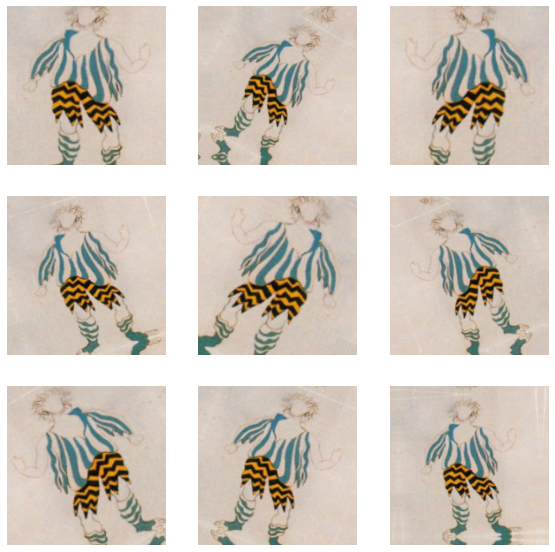

In [28]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 70  # figure size verkleinen
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [29]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)  # we voegen de data augmentation lagen toe aan ons model
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)  # we voegen een dropout laag toe
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [30]:
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

In [31]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch_with_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.7279 - loss: 0.6124 - val_accuracy: 0.8283 - val_loss: 0.4490
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.8362 - loss: 0.4778 - val_accuracy: 0.8283 - val_loss: 0.4522
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 0.8323 - loss: 0.4336 - val_accuracy: 0.8283 - val_loss: 0.4328
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.8158 - loss: 0.4452 - val_accuracy: 0.8283 - val_loss: 0.4055
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.8273 - loss: 0.4110 - val_accuracy: 0.8283 - val_loss: 0.3867
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - accuracy: 0.8213 - loss: 0.4152 - val_accuracy: 0.8283 - val_loss: 0.3794
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.8345 - loss: 0.4006 - val_accuracy: 0.8369 - val_loss: 0.3811
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.8182 - loss: 0.4041 - val_ac

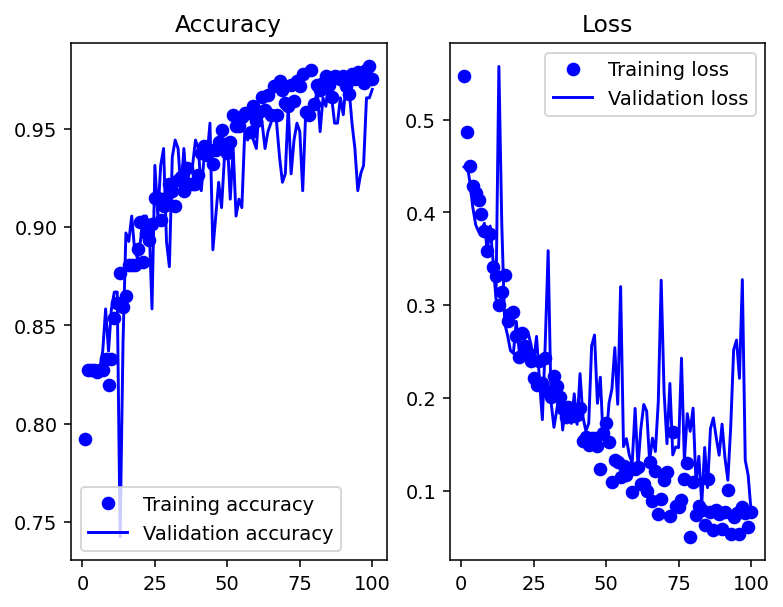

In [32]:
plt.rcParams['figure.dpi'] = 140  # figure size vergroten

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(epochs, accuracy, "bo", label="Training accuracy")
ax1.plot(epochs, val_accuracy, "b", label="Validation accuracy")
ax1.set_title("Accuracy")
ax1.legend();

ax2.plot(epochs, loss, "bo", label="Training loss")
ax2.plot(epochs, val_loss, "b", label="Validation loss")
ax2.set_title("Loss")
ax2.legend();

In [33]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.9532 - loss: 0.4426
Test accuracy: 0.949


In [34]:
from tensorflow import keras

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [35]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [37]:
print('Training:')
print("\tfeatures:", train_features.shape)
print("\tlabels:", train_labels.shape)
print('Validation:')
print("\tfeatures:", val_features.shape)
print("\tlabels:", val_labels.shape)
print('Test:')
print("\tfeatures:", test_features.shape)
print("\tlabels:", test_labels.shape)

Training:
	features: (1088, 5, 5, 512)
	labels: (1088,)
Validation:
	features: (233, 5, 5, 512)
	labels: (233,)
Test:
	features: (235, 5, 5, 512)
	labels: (235,)


In [44]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

In [45]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks
)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8334 - loss: 24.5442 - val_accuracy: 0.9399 - val_loss: 6.1344
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9824 - loss: 2.1116 - val_accuracy: 0.9614 - val_loss: 5.2320
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9946 - loss: 0.2968 - val_accuracy: 0.9614 - val_loss: 5.4311
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9901 - loss: 0.7471 - val_accuracy: 0.9700 - val_loss: 5.1434
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9902 - loss: 0.5988 - val_accuracy: 0.9700 - val_loss: 5.5653
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9927 - loss: 0.3835 - val_accuracy: 0.9785 - val_loss: 6.1482
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9985 - loss: 0.0802 - val_accuracy: 0.9700 - val_loss: 5.1740
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9977 - loss: 0.0227 - val_accuracy: 0.9442 - val_lo

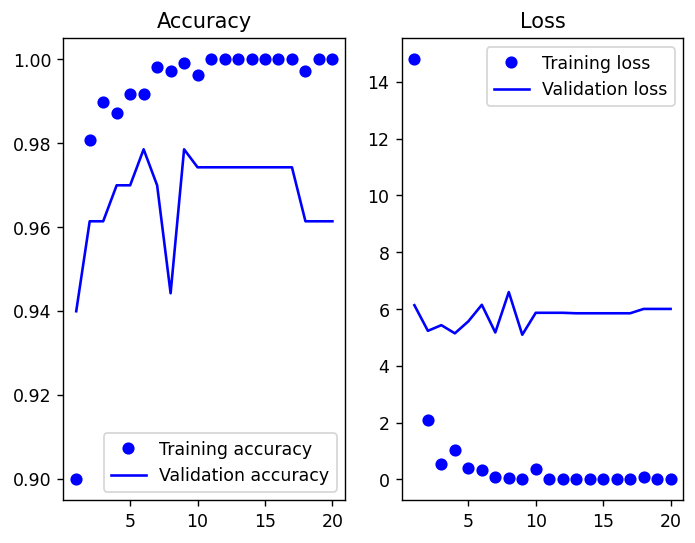

In [46]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 125  # figure size vergroten

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(epochs, acc, "bo", label="Training accuracy")
ax1.plot(epochs, val_acc, "b", label="Validation accuracy")
ax1.set_title("Accuracy")
ax1.legend();

ax2.plot(epochs, loss, "bo", label="Training loss")
ax2.plot(epochs, val_loss, "b", label="Validation loss")
ax2.set_title("Loss")
ax2.legend();

In [47]:
from tensorflow import keras

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
)

In [48]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [49]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [53]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

In [54]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - accuracy: 0.8079 - loss: 30.2326 - val_accuracy: 0.9399 - val_loss: 3.4120
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - accuracy: 0.9447 - loss: 3.2362 - val_accuracy: 0.9485 - val_loss: 5.0526
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.9588 - loss: 3.0234 - val_accuracy: 0.9528 - val_loss: 3.0785
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.9727 - loss: 1.5451 - val_accuracy: 0.9528 - val_loss: 4.4299
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.9660 - loss: 2.2046 - val_accuracy: 0.9356 - val_loss: 4.8482
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.9676 - loss: 2.6085 - val_accuracy: 0.9571 - val_loss: 4.2096
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.9762 - loss: 1.5404 - val_accuracy: 0.9528 - val_loss: 6.9721
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 178ms/step - accuracy: 0.9742 - loss: 1.4901 - val_accuracy

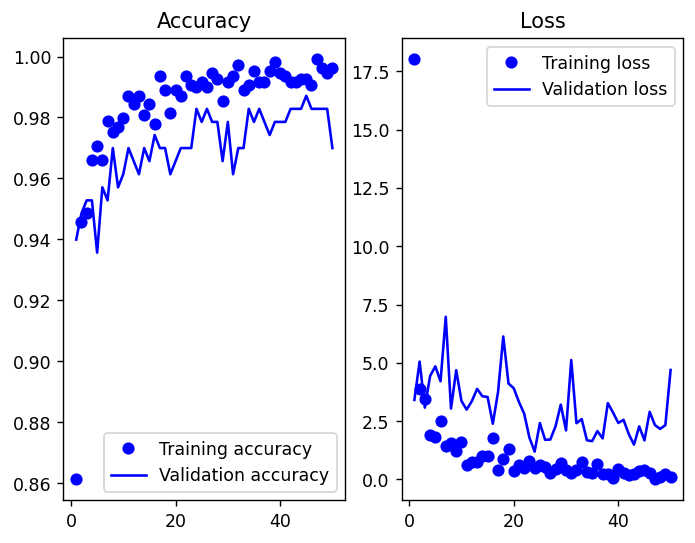

In [55]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(epochs, acc, "bo", label="Training accuracy")
ax1.plot(epochs, val_acc, "b", label="Validation accuracy")
ax1.set_title("Accuracy")
ax1.legend();

ax2.plot(epochs, loss, "bo", label="Training loss")
ax2.plot(epochs, val_loss, "b", label="Validation loss")
ax2.set_title("Loss")
ax2.legend();

In [56]:
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - accuracy: 0.9950 - loss: 0.3897
Test accuracy: 0.987


In [57]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"]
)

callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="fine_tuning.keras",
    save_best_only=True,
    monitor="val_loss")]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - accuracy: 0.9979 - loss: 0.0670 - val_accuracy: 0.9742 - val_loss: 2.6465
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 258ms/step - accuracy: 0.9961 - loss: 0.2092 - val_accuracy: 0.9785 - val_loss: 2.4827
Epoch 3/30
 2/34 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 7.1048e-33

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(epochs, acc, "bo", label="Training accuracy")
ax1.plot(epochs, val_acc, "b", label="Validation accuracy")
ax1.set_title("Accuracy")
ax1.legend();

ax2.plot(epochs, loss, "bo", label="Training loss")
ax2.plot(epochs, val_loss, "b", label="Validation loss")
ax2.set_title("Loss")
ax2.legend();

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")